In [ ]:
from google.colab import drive
drive.mount('/amd/')

Mounted at /amd/


In [ ]:
!cp /amd/My\ Drive/ODIR-5K_aug.zip /content/
# !cp /amd/My\ Drive/CSC490Data/vgg16_weights_tf_dim_ordering_tf_kernels.h5 /content/

In [ ]:
!unzip ODIR-5K_aug.zip

Streaming output truncated to the last 5000 lines.
  inflating: ODIR-5K/Training Images/2134_rightVFZM-C.jpg  
  inflating: ODIR-5K/Training Images/1276_left-G.jpg  
  inflating: ODIR-5K/Training Images/1624_leftVFZM-M.jpg  
  inflating: ODIR-5K/Training Images/2711_right-N.jpg  
  inflating: ODIR-5K/Training Images/499_right-H&D.jpg  
  inflating: ODIR-5K/Training Images/1833_rightZMRR-H.jpg  
  inflating: ODIR-5K/Training Images/1854_leftRB-A.jpg  
  inflating: ODIR-5K/Training Images/4026_left-N.jpg  
  inflating: ODIR-5K/Training Images/4604_left-D.jpg  
  inflating: ODIR-5K/Training Images/2242_leftBF-C.jpg  
  inflating: ODIR-5K/Training Images/1630_leftRR-M.jpg  
  inflating: ODIR-5K/Training Images/4615_right-D.jpg  
  inflating: ODIR-5K/Training Images/1833_rightZMRRRB-H.jpg  
  inflating: ODIR-5K/Training Images/759_rightRR-H.jpg  
  inflating: ODIR-5K/Training Images/1371_rightRR-G.jpg  
  inflating: ODIR-5K/Training Images/228_left-N.jpg  
  inflating: ODIR-5K/Training Imag

Most of the preparation work is taken from the Grzegors model.

Grzegorz model  https://github.com/GrzegorzMeller/AlgorithmsForMassiveData


In [ ]:
import tensorflow as tf
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import glob
import random

BATCH_SIZE = 32
IMG_HEIGHT = 250
IMG_WIDTH = 250
CLASS_NAMES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

In [ ]:
resampled1_ds =  tf.data.Dataset.list_files("ODIR-5K/Training Images/*.jpg")
test_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_Images/*.jpg")

In [ ]:
def get_label(name):
  parts = tf.strings.split(name, sep="-")
  label = tf.strings.split(parts[-1], sep=".")
  label = tf.strings.bytes_split(label[0])
  l = [0, 0, 0, 0, 0, 0, 0, 0]

  for e in label:
    if e != '&' and e != 'X':
      if e == 'N':
        l[0] = 1
      elif e == 'D':
        l[1] = 1
      elif e == 'G':
        l[2] = 1
      elif e == 'C':
        l[3] = 1
      elif e == 'A':
        l[4] = 1
      elif e == 'H':
        l[5] = 1
      elif e == 'M':
        l[6] = 1
      elif e == 'O':
        l[7] = 1

  return l

def get_name(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-1]

def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  #img = tf.image.adjust_contrast(img, 2)
  img = tf.image.convert_image_dtype(img, tf.float32)
  #img = tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
  return img

def process_path(file_path):
  name = get_name(file_path)
  label = get_label(name)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
resampled_named_ds = resampled1_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_named_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

(250, 250, 3)
label:  A [0 0 0 0 1 0 0 0]
(250, 250, 3)
label:  M [0 0 0 0 0 0 1 0]
(250, 250, 3)
label:  N [1 0 0 0 0 0 0 0]
(250, 250, 3)
label:  M [0 0 0 0 0 0 1 0]
(250, 250, 3)
label:  N [1 1 0 0 0 0 0 0]
(250, 250, 3)
label:  D [0 1 0 0 0 0 0 0]


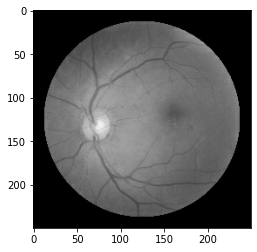

In [ ]:
#  Might need to 
for image, label in resampled_named_ds.take(6):
  print(image.shape)
  plt.imshow(image.numpy())
  print('label: ', CLASS_NAMES[np.nonzero(label.numpy()==1)[0][0]], label.numpy())

In [ ]:
def randomly_augment(image,label):
  image = tf.image.random_flip_left_right(image)
  #image = tf.image.central_crop(image, central_fraction=0.9)
  #image = tf.image.resize_with_pad(image, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
  return image, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  #ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=False)
  #ds = ds.map(randomly_augment, num_parallel_calls=AUTOTUNE)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE, drop_remainder=True)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  ds = ds.cache()
  ds = ds.batch(32, drop_remainder=True) #all elemetnts for training should be batched in one!
  ds = ds.repeat()

  return ds

In [ ]:
final_train_ds = prepare_for_training(resampled_named_ds,cache=True,shuffle_buffer_size=1000)
final_test_ds = prepare_for_testing(test_named_ds,cache=True,shuffle_buffer_size=100)

[0 0 0 0 1 0 0 0]


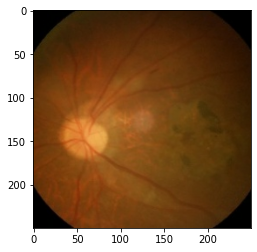

In [ ]:
for example in final_train_ds.take(1):
  image, label = example
  break
im, lab = image[13], label[13]
plt.imshow(im.numpy())
print(lab.numpy())

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(weights="imagenet",include_top = False,input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

#  TODO : if time permits I need to play around with letting few layer to be editable again
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(8,activation="sigmoid"))

checkpoint = ModelCheckpoint("vgg16.h5",monitor="val_accuracy",verbose=1, save_best_only=True, save_weights_only=False, period=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [ ]:
#  TODO : test with different optimizers such as SGD and Adam with different alphas
tf.random.set_seed(7) 
model.compile(optimizer="adam",loss="binary_crossentropy", metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

In [ ]:
history = model.fit(final_train_ds,
                    steps_per_epoch = 200, # todo update this varialbe since there is more data and it requires more steps which is # data / (batch size = 32)
                    epochs=25,
                    validation_data=final_test_ds,
                    validation_steps = 33,
                    verbose=1,
                    callbacks=[checkpoint,earlystop]
                    )

In [ ]:
model.evaluate(final_test_ds, steps=100)

In [ ]:
#  Grzegorz model  https://github.com/GrzegorzMeller/AlgorithmsForMassiveData

model_cnn = tf.keras.Sequential([
    
    # 1st VGG block
    tf.keras.layers.Conv2D(32, (5, 5), padding = "same", input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(32, (5, 5), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Dropout(0.45),

    #2nd VGG block
    tf.keras.layers.Conv2D(128, (5, 5), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(128, (5, 5), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Dropout(0.45),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(8, activation = 'sigmoid')
])

model_cnn.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 250, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 250, 250, 32)      96        
_________________________________________________________________
activation (Activation)      (None, 250, 250, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 250, 250, 32)      25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 250, 250, 32)      96        
_________________________________________________________________
activation_1 (Activation)    (None, 250, 250, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 83, 83, 32)        0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#  This is full VGG 16 model
tf.random.set_seed(7) 
model_cnn_deep_jordi = tf.keras.Sequential()
# 1st VGG block
layer = tf.keras.layers.Conv2D(64, (3, 3), padding = "same", input_shape=(IMG_HEIGHT, IMG_WIDTH ,3),activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))
layer.trainable = False
model_cnn_deep_jordi.add(layer)


#2nd VGG bloc
layer = tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))
layer.trainable = False
model_cnn_deep_jordi.add(layer)


#3nd VGG bloc
layer = tf.keras.layers.Conv2D(256, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.Conv2D(256, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.Conv2D(256, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))
layer.trainable = False
model_cnn_deep_jordi.add(layer)


#4nd VGG bloc
layer = tf.keras.layers.Conv2D(512, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.Conv2D(512, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.Conv2D(512, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))
layer.trainable = False
model_cnn_deep_jordi.add(layer)


#5nd VGG bloc
layer = tf.keras.layers.Conv2D(512, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.Conv2D(512, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.Conv2D(512, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))
layer.trainable = False
model_cnn_deep_jordi.add(layer)


layer = tf.keras.layers.Flatten()
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.Dense(4096, activation='relu')
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.Dense(4096, activation='relu')
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.Dense(1000, activation='softmax')
layer.trainable = False
model_cnn_deep_jordi.add(layer)

model_cnn_deep_jordi.load_weights("vgg16_weights_tf_dim_ordering_tf_kernels.h5")
model_cnn_deep_jordi.add(tf.keras.layers.Flatten()) # softmax or sigmoid
model_cnn_deep_jordi.add(tf.keras.layers.Dense(8, activation = 'sigmoid')) # softmax or sigmoid
# categorical_crossentropy  or binary_crossentropy
model_cnn_deep_jordi.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True), # Adam(learning_rate=0.0001)
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model_cnn_deep_jordi.summary()

In [ ]:
#  dont run the Grzegorz model, because it takes too long to train and does not provide reliable resluts with just 2 VGG blocks
# history_cnn = model_cnn.fit(final_train_ds.repeat(),
#                     #batch_size=32,
#                     epochs=50,
#                     steps_per_epoch = 450, #train_elements/batch_size
#                     validation_data=final_test_ds.repeat(),
#                     validation_steps = 60,
#                     use_multiprocessing=True,
#                     #class_weight=class_weight
#                     )

Epoch 1/50


TODO: clean this up

# Clean up: 

In [ ]:
# !zip -r mdl.zip mdl/

  adding: mdl/ (stored 0%)
  adding: mdl/saved_model.pb (deflated 91%)
  adding: mdl/assets/ (stored 0%)
  adding: mdl/variables/ (stored 0%)
  adding: mdl/variables/variables.index (deflated 71%)
  adding: mdl/variables/variables.data-00000-of-00002 (deflated 81%)
  adding: mdl/variables/variables.data-00001-of-00002 (deflated 8%)


In [ ]:
!cp -r mdl.zip /amd/My\ Drive

In [ ]:
!rm -rf ODIR-5K/

In [ ]:
!rm -f ODIR-5K_aug.zip